In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# from bs4 import BeautifulSoup
# import requests
from datetime import date

from   scipy.optimize import curve_fit
from   sklearn.linear_model import LinearRegression

%matplotlib inline

In [72]:
og_covid_2020 = pd.read_csv('NYT_2020_county_covid_date.csv')
og_covid_2021 = pd.read_csv('NYT_2021_county_covid_date.csv')
og_internet_df = pd.read_csv('internet_data.csv',encoding='ISO-8859-1')
og_fips_to_zip = pd.read_csv('ZIP-COUNTY-FIPS_2017-06.csv')
og_mobility_df = pd.read_csv("/Users/josephgreene/Library/CloudStorage/Box-Box/Trips_by_Distance.csv")
og_income_df = pd.read_excel("/Users/josephgreene/Library/CloudStorage/Box-Box/Unemployment.xlsx")

In [73]:
# https://www.ers.usda.gov/data-products/county-level-data-sets/download-data/

In [74]:
covid_2020 = og_covid_2020.copy()
covid_2021 = og_covid_2021.copy()
internet_df = og_internet_df.copy()
fips_to_zip = og_fips_to_zip.copy()
mobility_df = og_mobility_df.copy()
income_df = og_income_df.copy()

In [75]:
covid_2020_21 = covid_2020.append(covid_2021)

In [76]:
mobility_df['stay_rate'] = mobility_df['Population Staying at Home'] / (mobility_df['Population Not Staying at Home'] + mobility_df['Population Staying at Home'])

mobility_df['rec_stay_rate'] = mobility_df['stay_rate'].rolling(7).mean()
mobility_df['rec_stay_rating'] = pd.qcut(mobility_df['rec_stay_rate'], 6, labels=list(range(6)))

mobility_df = mobility_df.loc[mobility_df.Level == "County", ['Date','County FIPS','rec_stay_rate','rec_stay_rating']]
mobility_df['Date'] = pd.to_datetime(mobility_df.Date)

In [77]:
mobility_df

,Date,County FIPS,rec_stay_rate,rec_stay_rating
21061,2021-06-06,56045.0,0.187358,2
22762,2021-06-06,5011.0,0.174663,1
22763,2021-06-06,5013.0,0.167635,1
22764,2021-06-06,5015.0,0.163786,1
22765,2021-06-06,5017.0,0.159113,0
...,...,...,...,...
3391659,2021-11-27,1095.0,0.165085,1
3391660,2021-11-27,1097.0,0.163170,1
3391661,2021-11-27,1099.0,0.169806,1
3391662,2021-11-27,1101.0,0.177356,2


In [78]:
covid_2020_21['date'] = pd.to_datetime(covid_2020_21['date'])
covid_2020_21.sort_values(by="date", inplace=True)
covid_2020_21['tot_deaths'] = covid_2020_21.groupby('county')['deaths'].cumsum(axis=0)
covid_2020_21['tot_cases'] = covid_2020_21.groupby('county')['cases'].cumsum(axis=0)
covid_2020_21['death_rate'] = covid_2020_21['tot_deaths'] / covid_2020_21['tot_cases']
covid_2020_21['fips_code'] = pd.to_numeric(covid_2020_21['geoid'].str.lstrip('USA-'))
covid_2020_21['dr_rating'] = pd.qcut(x=covid_2020_21.death_rate, q=6, labels = range(6))
covid_2020_21 = pd.merge(covid_2020_21, mobility_df, how='left', left_on=['date','fips_code'], right_on=['Date','County FIPS'])
covid_2020_21.drop(columns=['geoid','County FIPS', 'cases_avg','cases_avg_per_100k', 'deaths_avg','deaths_avg_per_100k','Date'],inplace=True)

In [79]:
covid_2020_21

,date,county,state,cases,deaths,tot_deaths,tot_cases,death_rate,fips_code,dr_rating,rec_stay_rate,rec_stay_rating
0,2020-01-21,Snohomish,Washington,1,0,0,1,0.000000,53061,0,0.182117,2
1,2020-01-22,Snohomish,Washington,0,0,0,1,0.000000,53061,0,0.179765,2
2,2020-01-23,Snohomish,Washington,0,0,0,1,0.000000,53061,0,0.187750,2
3,2020-01-24,Snohomish,Washington,0,0,0,1,0.000000,53061,0,0.194106,3
4,2020-01-24,Cook,Illinois,1,0,0,1,0.000000,17031,0,0.196440,3
...,...,...,...,...,...,...,...,...,...,...,...,...
1933537,2021-11-17,Canadian,Oklahoma,206,0,295,23744,0.012424,40017,1,0.190273,2
1933538,2021-11-17,Caddo,Oklahoma,25,0,1107,45150,0.024518,40015,4,0.182528,2
1933539,2021-11-17,Bryan,Oklahoma,69,0,180,15443,0.011656,40013,1,0.172932,1
1933540,2021-11-17,Cotton,Oklahoma,11,0,23,1006,0.022863,40033,4,0.178909,2


In [80]:
covid_2020_21.to_csv('/Users/josephgreene/Library/CloudStorage/Box-Box/project_county_covid_data')

0         2020-01-21
1         2020-01-22
2         2020-01-23
3         2020-01-24
4         2020-01-24
             ...    
1933537   2021-11-17
1933538   2021-11-17
1933539   2021-11-17
1933540   2021-11-17
1933541   2021-11-17
Name: date, Length: 1933542, dtype: datetime64[ns]

In [213]:
covid_2020_21.sample()

,date,county,state,cases,cases_avg,cases_avg_per_100k,deaths,deaths_avg,deaths_avg_per_100k,tot_deaths,tot_cases,death_rate,fips_code,dr_rating,Date,stay_rate,stay_rating
362677,2020-07-23,Montgomery,Maryland,61,85.43,8.13,5,2.57,0.24,1910,42950,0.04447,24031,5,2020-07-23,0.285467,5


In [253]:
temp_df = covid_2020_21.groupby(by='date')

<AxesSubplot:xlabel='date,None'>

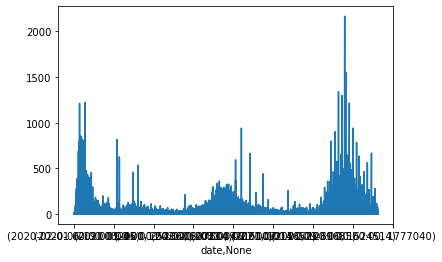

In [287]:
temp_df.deaths.rolling(7).sum().loc[temp_df.deaths.rolling(7).sum() >= 0].plot()

In [300]:
temp_df.rolling(7).sum().loc[temp_df.deaths.rolling(7).sum() >= 0].index

MultiIndex([('2020-02-01',      45),
            ('2020-02-02',      52),
            ('2020-02-02',      53),
            ('2020-02-03',      60),
            ('2020-02-03',      61),
            ('2020-02-04',      68),
            ('2020-02-04',      69),
            ('2020-02-05',      76),
            ('2020-02-05',      77),
            ('2020-02-05',      78),
            ...
            ('2021-11-17', 1933532),
            ('2021-11-17', 1933533),
            ('2021-11-17', 1933534),
            ('2021-11-17', 1933535),
            ('2021-11-17', 1933536),
            ('2021-11-17', 1933537),
            ('2021-11-17', 1933538),
            ('2021-11-17', 1933539),
            ('2021-11-17', 1933540),
            ('2021-11-17', 1933541)],
           names=['date', None], length=1905040)

KeyboardInterrupt: 

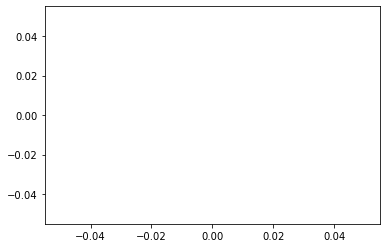

In [295]:
# plot = 
sns.lineplot(
    y=temp_df.deaths.rolling(7).sum().loc[temp_df.deaths.rolling(7).sum() >= 0],

)
# plt.figure(figsize=(24,8))

# plt.show()

In [10]:
temp_df = covid_2020_21.groupby(by='county')
county_overall_df = temp_df.var()


In [11]:
# fig, ax = plt.subplots()
# ax.plot(temp_df.size())
# plt.ylabel('# counties reporting')
# plt.xlabel('Date')
# fig.set_size_inches(24,3)
# plt.title("# of Counties reporting each day".title())
# plt.show()

In [12]:
good_reporting = 3000

In [13]:
pd.value_counts(temp_df.size() >= 3000)

False    1850
True       80
dtype: int64

In [15]:
temp_df
temp_df.var()

,cases,cases_avg,cases_avg_per_100k,deaths,deaths_avg,deaths_avg_per_100k,tot_deaths,tot_cases,death_rate,fips_code
county,,,,,,,,,,
Abbeville,117.555311,40.167678,667.732214,0.108380,0.015184,0.248787,295.741482,1.570481e+06,0.000057,0.000000e+00
Acadia,777.544710,313.293579,813.827967,0.808327,0.215753,0.558824,5896.851826,1.006567e+07,0.000165,0.000000e+00
Accomack,116.192553,54.376679,520.698856,0.180352,0.034713,0.330766,399.355838,1.287805e+06,0.000015,0.000000e+00
Ada,22793.388485,14970.667741,645.490924,5.494357,2.073266,0.089009,52026.839109,6.482325e+08,0.000029,0.000000e+00
Adair,176.949171,47.858702,1128.953246,0.189821,0.024519,1.436079,4380.570739,1.877116e+07,0.000549,6.829426e+07
...,...,...,...,...,...,...,...,...,...,...
Yukon-Koyukuk Census Area,11.450652,3.057183,1117.860404,0.015013,0.002010,0.739828,3.286688,4.110734e+04,0.000042,0.000000e+00
Yuma,7490.933853,5467.148893,1204.560467,4.684099,2.506089,0.900411,113839.379950,2.391103e+08,0.000040,4.201839e+06
Zapata,75.685457,25.152011,1251.057910,0.117921,0.024052,1.194266,266.808093,6.821003e+05,0.000055,0.000000e+00


In [9]:
internet_df = og_internet_df.copy()
fips_to_zip = og_fips_to_zip.copy()

In [10]:
col_to_keep_internet = [
    'Zip',
    'County',
    'State', 
#     'AllProviderCount_2020', 
#     'All25_3_2020', 
#     'All100_3',
#     'TestCount',
    'AverageMbps', 
#     'FastestAverageMbps'
]
internet_df = internet_df.copy().loc[:,col_to_keep_internet]

In [12]:
internet_df

,Zip,County,State,AverageMbps
0,29620,Abbeville,South Carolina,212.50
1,29628,Abbeville,South Carolina,51.12
2,29638,Abbeville,South Carolina,82.79
3,29639,Abbeville,South Carolina,93.12
4,70516,Acadia,Louisiana,2.76
...,...,...,...,...
32603,99781,Yukon-Koyukuk,Alaska,0.43
32604,99788,Yukon-Koyukuk,Alaska,NaN
32605,99774,Yukon-Koyukuk,Alaska,NaN
32606,99767,Yukon-Koyukuk,Alaska,NaN


In [13]:
internet_df = internet_df.groupby(by=['County','State']).mean()

In [14]:
# col_to_sum = 'AllProviderCount_2020	All25_3_2020	All100_3	TestCount'.split('\t')
# # internet_df[col_to_sum] = 
# internet_df[col_to_sum].groupby(by=['County','State']).mean()
# # internet_df[['County','All100_3']].groupby(by='County').mean()

In [15]:
# https://www.ssa.gov/international/coc-docs/states.html for list below (non-states except d.c. removed)
names_abbs = '''ALABAMA	AL
                ALASKA	AK
                ARIZONA	AZ
                ARKANSAS	AR
                CALIFORNIA	CA
                COLORADO	CO
                CONNECTICUT	CT
                DELAWARE	DE
                DISTRICT OF COLUMBIA	DC
                FLORIDA	FL
                GEORGIA	GA
                HAWAII	HI
                IDAHO	ID
                ILLINOIS	IL
                INDIANA	IN
                IOWA	IA
                KANSAS	KS
                KENTUCKY	KY
                LOUISIANA	LA
                MAINE	ME
                MARYLAND	MD
                MASSACHUSETTS	MA
                MICHIGAN	MI
                MINNESOTA	MN
                MISSISSIPPI	MS
                MISSOURI	MO
                MONTANA	MT
                NEBRASKA	NE
                NEVADA	NV
                NEW HAMPSHIRE	NH
                NEW JERSEY	NJ
                NEW MEXICO	NM
                NEW YORK	NY
                NORTH CAROLINA	NC
                NORTH DAKOTA	ND
                OHIO	OH
                OKLAHOMA	OK
                OREGON	OR
                PENNSYLVANIA	PA
                RHODE ISLAND	RI
                SOUTH CAROLINA	SC
                SOUTH DAKOTA	SD
                TENNESSEE	TN
                TEXAS	TX
                UTAH	UT
                VERMONT	VT
                VIRGINIA	VA
                WASHINGTON	WA
                WEST VIRGINIA	WV
                WISCONSIN	WI
                WYOMING	WY'''

names_abbs = [i.strip().split('\t') for i in names_abbs.split('\n')]
names_abbs = {i[0].title():i[1] for i in names_abbs}

names_abbs_df = pd.DataFrame({
    'State':names_abbs.keys(),
    'State_abbr':names_abbs.values()                        
                            })

In [16]:
# internet_df aning fips_to_zip df

col_to_keep_fips_to_zip = [
#     'ZIP',
    'COUNTYNAME', 
    'STATE',
    'STCOUNTYFP',
#   'CLASSFP'
    ]
fips_to_zip = fips_to_zip.loc[:,col_to_keep_fips_to_zip]
fips_to_zip.rename(columns={'ZIP':'Zip','STCOUNTYFP':"fips_code","STATE":"State_abbr","COUNTYNAME":"County"},inplace=True)
fips_to_zip['County'] = fips_to_zip.County.apply(lambda x: x[:-7])
fips_to_zip = pd.merge(fips_to_zip,names_abbs_df,on='State_abbr')
fips_to_zip.drop_duplicates(subset='fips_code',inplace=True)


In [17]:
internet_df.shape

(3213, 2)

In [18]:
internet_df = pd.merge(internet_df, fips_to_zip.loc[:,['County','fips_code','State']], on=['County','State'], how='left').sort_values(by='fips_code')


In [19]:
internet_df = internet_df.loc[pd.notnull(internet_df['fips_code'])].set_index('fips_code')

In [20]:
# col_to_sum = 'AllProviderCount_2020	All25_3_2020	All100_3	TestCount'.split('\t')
# internet_df[col_to_sum] = 
# internet_df[col_to_sum] = internet_df[col_to_sum+['County','State']].groupby(by='County').mean()

In [21]:
internet_df['avg_mbps_rating'] = pd.qcut(x=internet_df.AverageMbps, q=6, labels = range(6))
# internet_df['fast_mbps_rating'] = pd.qcut(x=internet_df.FastestAverageMbps, q=6, labels = range(6))

In [22]:
internet_df.drop(columns=['County','State','Zip'], inplace=True)

In [30]:
income_df = og_income_df.copy()

In [31]:
income_df.columns = income_df.iloc[3]
income_df = income_df.loc[:, ['FIPS_Code', 'Median_Household_Income_2019']]
income_df = income_df.iloc[4:]

In [32]:
internet_df.shape


(3054, 2)

In [33]:
income_df

3,FIPS_Code,Median_Household_Income_2019
4,00000,65712
5,01000,51771
6,01001,58233
7,01003,59871
8,01005,35972
...,...,...
3274,72145,NaN
3275,72147,NaN
3276,72149,NaN
3277,72151,NaN


In [34]:
static_df = pd.merge(internet_df, income_df, how='outer', left_on=internet_df.index, right_on=pd.to_numeric(income_df.FIPS_Code))
static_df.drop(columns=['key_0'], inplace=True)
static_df.rename(columns={'Median_Household_Income_2019':'med_income'},inplace=True)

In [36]:
static_df.to_csv('project_county_static_data')

,AverageMbps,avg_mbps_rating,FIPS_Code,med_income
0,38.218333,3,01001,58233
1,50.272632,4,01003,59871
2,52.206667,4,01005,35972
3,23.557143,2,01007,47918
4,29.145714,2,01009,52902
...,...,...,...,...
3270,NaN,NaN,72145,NaN
3271,NaN,NaN,72147,NaN
3272,NaN,NaN,72149,NaN
3273,NaN,NaN,72151,NaN
